# 18. Brownian Motion: Properties

**Goal:** Numerically verify the remarkable analytic properties of Brownian motion.

Brownian motion is the canonical example of a process that is:
- **Continuous** everywhere (a.s.)
- **Nowhere differentiable** (a.s.)
- Has **quadratic variation** $[B]_t = t$
- Is **self-similar:** $B(ct) \stackrel{d}{=} \sqrt{c}\, B(t)$

These properties are deeply tied to the measure-theoretic structure of Wiener measure on path space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Continuity and Nowhere Differentiability

Although $B_t$ is continuous, the finite-difference approximation to its derivative:
$$\frac{B(t+h) - B(t)}{h}$$
does **not** converge as $h \to 0$. In fact, $|B(t+h) - B(t)| \sim \sqrt{h}$, so the ratio blows up as $h^{-1/2}$.

This is a consequence of the Holder continuity exponent being $1/2 - \varepsilon$ for any $\varepsilon > 0$, but never $1/2$.

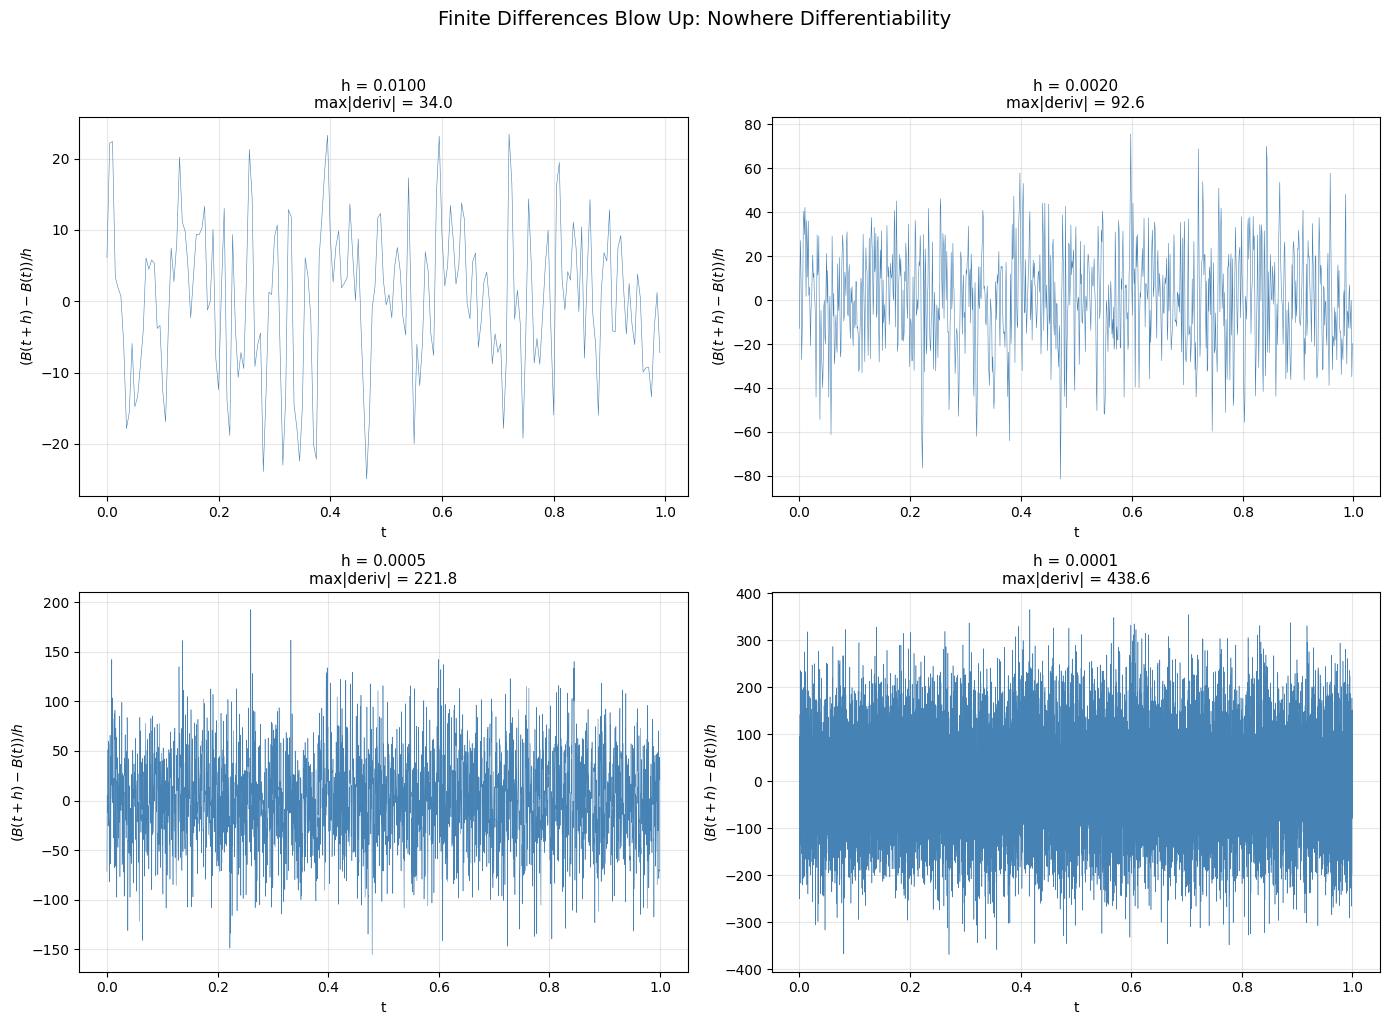

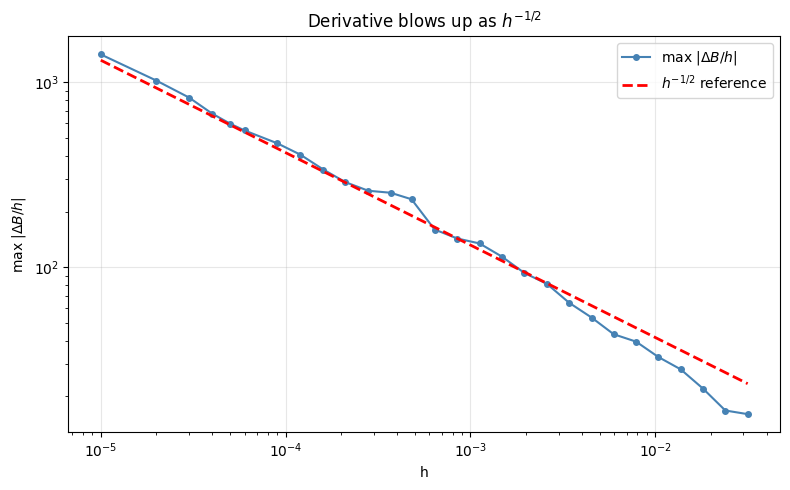

In [2]:
np.random.seed(42)

# Generate a fine Brownian motion path
n_fine = 100000
T = 1.0
dt_fine = T / n_fine
t_fine = np.linspace(0, T, n_fine + 1)
B = np.concatenate([[0], np.cumsum(np.sqrt(dt_fine) * np.random.randn(n_fine))])

# Compute finite-difference "derivatives" at different scales
h_values = [1000, 200, 50, 10]  # in units of dt_fine
h_labels = [f'h = {h * dt_fine:.4f}' for h in h_values]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (h_steps, label) in enumerate(zip(h_values, h_labels)):
    ax = axes[idx]
    h = h_steps * dt_fine
    # Finite difference at each point
    deriv = (B[h_steps:] - B[:-h_steps]) / h
    t_deriv = t_fine[:-h_steps]
    
    ax.plot(t_deriv[::max(1, h_steps//2)], deriv[::max(1, h_steps//2)],
            linewidth=0.4, color='steelblue')
    ax.set_title(f'{label}\nmax|deriv| = {np.max(np.abs(deriv)):.1f}', fontsize=11)
    ax.set_xlabel('t'); ax.set_ylabel('$(B(t+h) - B(t))/h$')
    ax.grid(True, alpha=0.3)

plt.suptitle('Finite Differences Blow Up: Nowhere Differentiability', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Quantitative: max of |derivative| vs h
h_range = np.logspace(0, 3.5, 30).astype(int)
h_range = np.unique(np.clip(h_range, 1, n_fine // 2))
max_derivs = []
for h_steps in h_range:
    h = h_steps * dt_fine
    deriv = (B[h_steps:] - B[:-h_steps]) / h
    max_derivs.append(np.max(np.abs(deriv)))

fig, ax = plt.subplots(figsize=(8, 5))
h_actual = h_range * dt_fine
ax.loglog(h_actual, max_derivs, 'o-', color='steelblue', markersize=4, label='max $|\\Delta B/h|$')
# Reference line: h^{-1/2}
c_ref = max_derivs[len(max_derivs)//2] * h_actual[len(h_actual)//2]**0.5
ax.loglog(h_actual, c_ref * h_actual**(-0.5), 'r--', linewidth=2, label='$h^{-1/2}$ reference')
ax.set_xlabel('h'); ax.set_ylabel('max $|\\Delta B / h|$')
ax.set_title('Derivative blows up as $h^{-1/2}$', fontsize=12)
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Quadratic Variation: $[B]_t = t$

For a partition $\Pi = \{0 = t_0 < t_1 < \cdots < t_n = t\}$ with mesh $|\Pi| \to 0$:
$$[B]_t = \lim_{|\Pi| \to 0} \sum_{k=0}^{n-1} (B_{t_{k+1}} - B_{t_k})^2 = t \quad \text{(in } L^2 \text{ and a.s.)}$$

This is fundamentally different from smooth functions, whose quadratic variation is always 0.
It is the key reason why stochastic calculus differs from ordinary calculus.

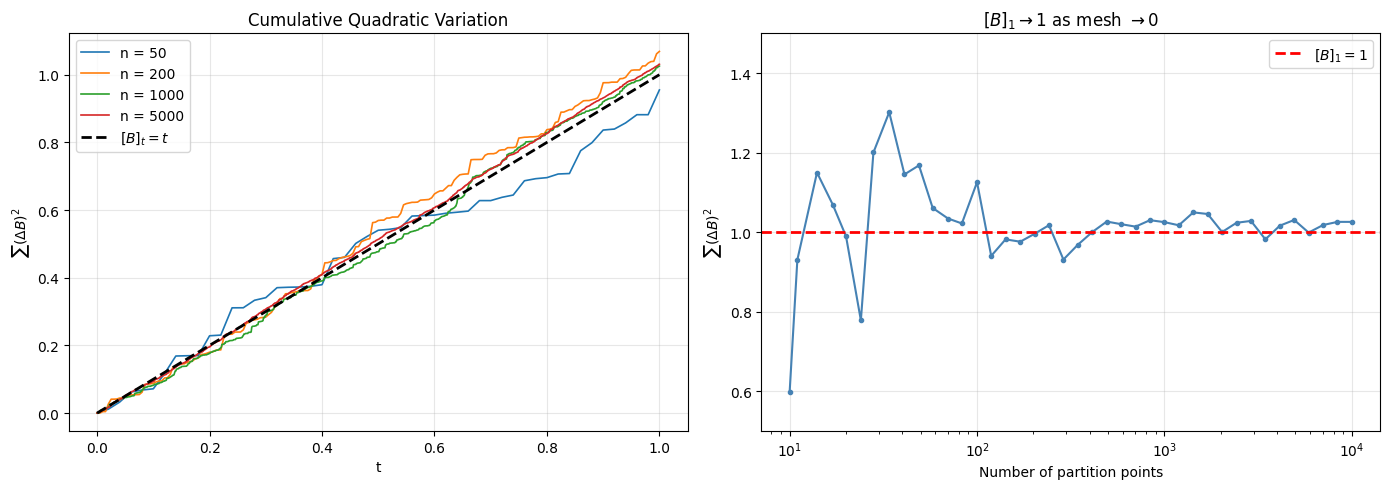

First variation (total variation) comparison:
  n=  100:  first variation = 8.448,  quadratic variation = 1.1257
  n=  500:  first variation = 18.187,  quadratic variation = 1.0292
  n= 2000:  first variation = 35.729,  quadratic variation = 1.0308
  n=10000:  first variation = 80.417,  quadratic variation = 1.0260

First variation -> infinity, quadratic variation -> 1


In [3]:
np.random.seed(2024)

T = 1.0
n_fine = 50000
dt_fine = T / n_fine
t_fine = np.linspace(0, T, n_fine + 1)
B = np.concatenate([[0], np.cumsum(np.sqrt(dt_fine) * np.random.randn(n_fine))])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: QV as function of t for different partition sizes
n_partitions = [50, 200, 1000, 5000]
for n_part in n_partitions:
    step = n_fine // n_part
    indices = np.arange(0, n_fine + 1, step)
    B_part = B[indices]
    t_part = t_fine[indices]
    increments_sq = np.diff(B_part)**2
    qv_cumulative = np.concatenate([[0], np.cumsum(increments_sq)])
    ax1.plot(t_part, qv_cumulative, linewidth=1.2, label=f'n = {n_part}')

ax1.plot([0, T], [0, T], 'k--', linewidth=2, label='$[B]_t = t$')
ax1.set_xlabel('t'); ax1.set_ylabel('$\\sum (\\Delta B)^2$')
ax1.set_title('Cumulative Quadratic Variation', fontsize=12)
ax1.legend(); ax1.grid(True, alpha=0.3)

# Right: total QV at t=1 for many partition sizes
n_range = np.logspace(1, 4, 40).astype(int)
n_range = np.unique(n_range)
qv_totals = []
for n_part in n_range:
    step = max(1, n_fine // n_part)
    indices = np.arange(0, n_fine + 1, step)
    increments_sq = np.diff(B[indices])**2
    qv_totals.append(np.sum(increments_sq))

ax2.semilogx(n_range, qv_totals, 'o-', color='steelblue', markersize=3)
ax2.axhline(y=T, color='red', linestyle='--', linewidth=2, label='$[B]_1 = 1$')
ax2.set_xlabel('Number of partition points')
ax2.set_ylabel('$\\sum (\\Delta B)^2$')
ax2.set_title('$[B]_1 \\to 1$ as mesh $\\to 0$', fontsize=12)
ax2.legend(); ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.5, 1.5)

plt.tight_layout()
plt.show()

# Compare with first variation (total variation)
print('First variation (total variation) comparison:')
for n_part in [100, 500, 2000, 10000]:
    step = max(1, n_fine // n_part)
    indices = np.arange(0, n_fine + 1, step)
    fv = np.sum(np.abs(np.diff(B[indices])))
    qv = np.sum(np.diff(B[indices])**2)
    print(f'  n={n_part:5d}:  first variation = {fv:.3f},  quadratic variation = {qv:.4f}')
print('\nFirst variation -> infinity, quadratic variation -> 1')

## Self-Similarity

Brownian motion has a scaling property: for any $c > 0$,
$$\{B(ct)\}_{t \geq 0} \stackrel{d}{=} \{\sqrt{c}\, B(t)\}_{t \geq 0}$$

This means zooming into a Brownian path (rescaling time by $c$ and space by $\sqrt{c}$) yields a statistically identical process. We verify this by comparing distributions at fixed times.

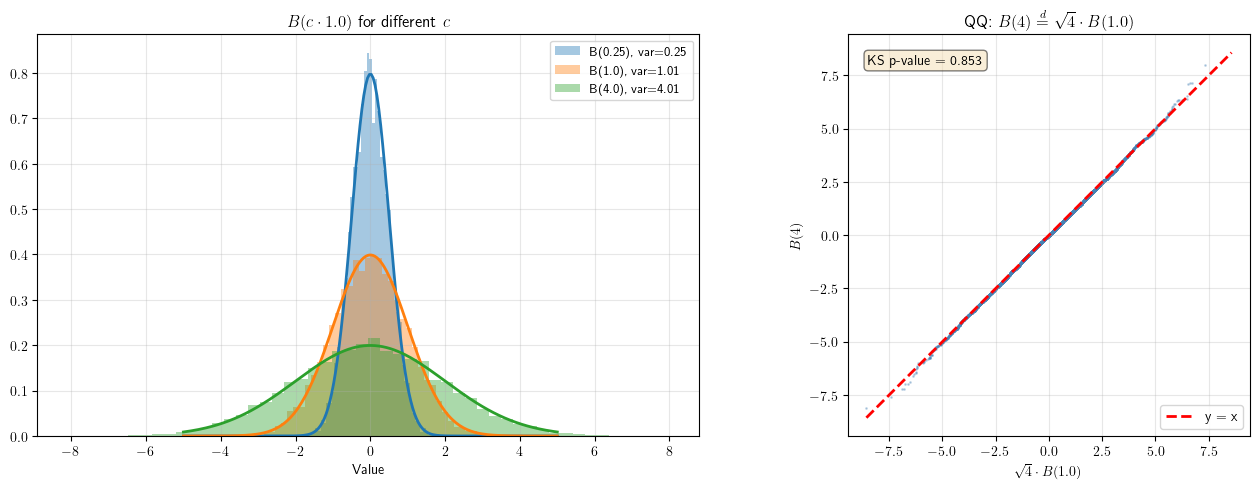

In [4]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

np.random.seed(777)

n_paths = 10000
n_steps = 2000
T = 4.0
dt = T / n_steps
t_grid = np.linspace(0, T, n_steps + 1)

inc = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
B = np.zeros((n_paths, n_steps + 1))
B[:, 1:] = np.cumsum(inc, axis=1)

c_values = [0.25, 1.0, 4.0]
t_eval = 1.0  # evaluate at t=1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: visual comparison of B(ct) and sqrt(c)*B(t)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
x_range = np.linspace(-5, 5, 200)

for c, color in zip(c_values, colors):
    ct_idx = min(int(c * t_eval / dt), n_steps)
    B_ct = B[:, ct_idx]  # B(c*t)
    scaled_B = np.sqrt(c) * B[:, int(t_eval / dt)]  # sqrt(c) * B(t)
    
    ax1.hist(B_ct, bins=50, density=True, alpha=0.4, color=color,
             label=f'B({c}), var={np.var(B_ct):.2f}')
    ax1.plot(x_range, stats.norm.pdf(x_range, 0, np.sqrt(c * t_eval)),
             color=color, linewidth=2)

ax1.set_title(f'$B(c \\cdot {t_eval})$ for different $c$', fontsize=12)
ax1.set_xlabel('Value'); ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: QQ plot comparing B(ct) vs sqrt(c)*B(t)
c_test = 4.0
ct_idx = min(int(c_test * t_eval / dt), n_steps)
t_idx = int(t_eval / dt)
B_ct = np.sort(B[:, ct_idx])
scaled_B = np.sort(np.sqrt(c_test) * B[:, t_idx])

ax2.scatter(scaled_B, B_ct, s=1, alpha=0.3, color='steelblue')
lim = max(np.abs(B_ct).max(), np.abs(scaled_B).max())
ax2.plot([-lim, lim], [-lim, lim], 'r--', linewidth=2, label='y = x')
ax2.set_xlabel(f'$\\sqrt{{{c_test:.0f}}} \\cdot B({t_eval})$')
ax2.set_ylabel(f'$B({c_test * t_eval:.0f})$')
ax2.set_title(f'QQ: $B({c_test:.0f}) \\stackrel{{d}}{{=}} \\sqrt{{{c_test:.0f}}} \\cdot B({t_eval})$', fontsize=12)
ax2.legend(); ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

# KS test
ks_stat, ks_p = stats.ks_2samp(B[:, ct_idx], np.sqrt(c_test) * B[:, t_idx])
ax2.text(0.05, 0.95, f'KS p-value = {ks_p:.3f}', transform=ax2.transAxes,
         fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Reflection Principle and Hitting Times

The **reflection principle** states: for a level $a > 0$,
$$P(\max_{0 \leq s \leq t} B_s \geq a) = 2\, P(B_t \geq a) = 2\,[1 - \Phi(a/\sqrt{t})]$$

The **first hitting time** $\tau_a = \inf\{t \geq 0 : B_t = a\}$ has the Levy distribution:
$$f_{\tau_a}(t) = \frac{|a|}{\sqrt{2\pi t^3}}\, \exp\!\left(-\frac{a^2}{2t}\right), \quad t > 0$$

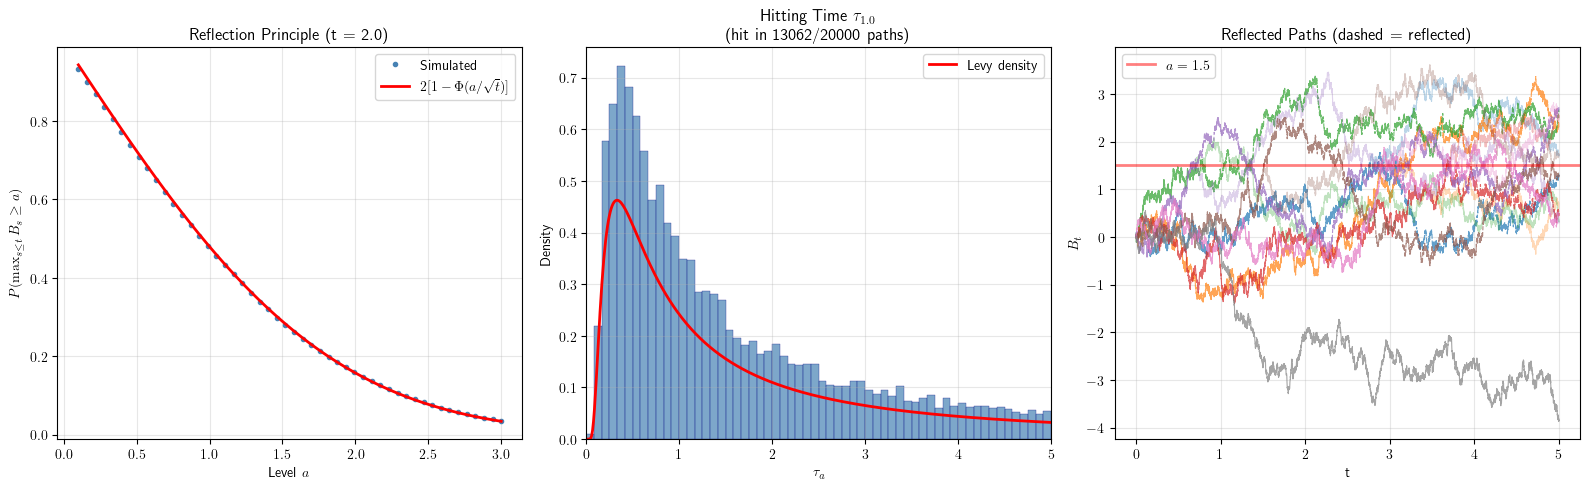

In [5]:
np.random.seed(2024)

n_paths = 20000
n_steps = 10000
T = 5.0
dt = T / n_steps
t_grid = np.linspace(0, T, n_steps + 1)

inc = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
B = np.zeros((n_paths, n_steps + 1))
B[:, 1:] = np.cumsum(inc, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: reflection principle verification
ax = axes[0]
a_values = np.linspace(0.1, 3.0, 50)
t_check = 2.0
t_idx = int(t_check / dt)
running_max = np.max(B[:, :t_idx+1], axis=1)

prob_max_empirical = [np.mean(running_max >= a) for a in a_values]
prob_max_theory = [2 * (1 - stats.norm.cdf(a / np.sqrt(t_check))) for a in a_values]

ax.plot(a_values, prob_max_empirical, 'o', markersize=3, color='steelblue', label='Simulated')
ax.plot(a_values, prob_max_theory, 'r-', linewidth=2, label='$2[1-\\Phi(a/\\sqrt{t})]$')
ax.set_xlabel('Level $a$'); ax.set_ylabel('$P(\\max_{s \\leq t} B_s \\geq a)$')
ax.set_title(f'Reflection Principle (t = {t_check})', fontsize=12)
ax.legend(); ax.grid(True, alpha=0.3)

# Middle: hitting time distribution
ax = axes[1]
a = 1.0
hit_times = []
for i in range(n_paths):
    crossings = np.where(B[i, :] >= a)[0]
    if len(crossings) > 0:
        hit_times.append(crossings[0] * dt)

hit_times = np.array(hit_times)
t_range = np.linspace(0.01, T, 500)
levy_pdf = (a / np.sqrt(2 * np.pi * t_range**3)) * np.exp(-a**2 / (2 * t_range))

ax.hist(hit_times, bins=60, density=True, color='steelblue', alpha=0.7,
        edgecolor='navy', linewidth=0.3, range=(0, T))
ax.plot(t_range, levy_pdf, 'r-', linewidth=2, label='Levy density')
ax.set_xlabel('$\\tau_a$'); ax.set_ylabel('Density')
ax.set_title(f'Hitting Time $\\tau_{{{a}}}$\n(hit in {len(hit_times)}/{n_paths} paths)', fontsize=12)
ax.legend(); ax.grid(True, alpha=0.3)
ax.set_xlim(0, T)

# Right: reflected paths
ax = axes[2]
a_reflect = 1.5
n_show = 8
for i in range(n_show):
    path = B[i].copy()
    cross_idx = np.where(path >= a_reflect)[0]
    if len(cross_idx) > 0:
        first_cross = cross_idx[0]
        # Original path
        ax.plot(t_grid[:first_cross+1], path[:first_cross+1],
                color=f'C{i}', linewidth=0.8, alpha=0.7)
        ax.plot(t_grid[first_cross:], path[first_cross:],
                color=f'C{i}', linewidth=0.8, alpha=0.3)
        # Reflected path
        reflected = 2 * a_reflect - path[first_cross:]
        ax.plot(t_grid[first_cross:], reflected,
                color=f'C{i}', linewidth=0.8, alpha=0.7, linestyle='--')
    else:
        ax.plot(t_grid, path, color=f'C{i}', linewidth=0.8, alpha=0.7)

ax.axhline(y=a_reflect, color='red', linestyle='-', linewidth=2, alpha=0.5, label=f'$a = {a_reflect}$')
ax.set_xlabel('t'); ax.set_ylabel('$B_t$')
ax.set_title('Reflected Paths (dashed = reflected)', fontsize=12)
ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

1. **Nowhere differentiable:** finite-difference derivatives diverge as $h^{-1/2}$ -- Brownian paths are Holder-$\alpha$ only for $\alpha < 1/2$.
2. **Quadratic variation $[B]_t = t$:** this is the fundamental reason stochastic calculus differs from ordinary calculus. Smooth functions have zero quadratic variation; Brownian motion does not.
3. **First variation is infinite:** $\sum |\Delta B| \to \infty$ as the mesh refines, confirming infinite total variation on every interval.
4. **Self-similarity:** $B(ct) \stackrel{d}{=} \sqrt{c}\,B(t)$ -- zooming in reveals statistically identical structure at every scale.
5. **Reflection principle:** $P(\max_{s \leq t} B_s \geq a) = 2P(B_t \geq a)$, leading to the Levy distribution for hitting times.
6. These properties make Brownian motion a natural model for financial log-returns and the foundation of Ito calculus.